In [7]:
import noise_calc
import prop_simulate
import prop_design
import optimization_NSGA2
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [4]:
Diameter_m = 3;
SpinnerCutoff = 0.2
NumberOfBlades = 2
ObjectiveThrust_N = 4000
AxialVelocity_m_s = 0
ForwardVelocity_m_s = 0
ClMachPolars = pd.read_csv("ClarkYClPolar.dat", header = 1)
CdMachPolars = pd.read_csv("ClarkYCdPolar.dat", header = 1)
NumberOfStations = 11
Convergence = 0.01 #Newton

DistanceToObserver_m = 150
AngleToObserver_deg = 30  #Angle from Negative thrust to observer

SoundSpeed_m_s = 343
AirDensity_Kg_m3 = 1.225

In [5]:
def Evaluation(Chromossome):
  Croot_adim = Chromossome["Croot"]
  Cmax_adim = Chromossome["Cmax"]
  Smax_adim = Chromossome["Smax"]
  Ctip_adim = Chromossome["Ctip"]
  Pitch_m = Chromossome["Pitch"]
  Colective_deg = Chromossome["Collective"]

  #c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
  a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
  b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
  c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
  d = Croot_adim**2

  S = np.linspace(0, 0.9999, NumberOfStations, endpoint = True)
  RadialStations_adim = [SpinnerCutoff + (1 - SpinnerCutoff)*s for s in S]
  RadialStations_m = [r*Diameter_m/2 for r in RadialStations_adim]

  ChordDistribution_m = [((a*s**3 + b*s**2 + c*s + d)**0.5)*Diameter_m/2 for s in S]

  TwistDistribution_deg = prop_design.simple_pitch(RadialStations_m, Pitch_m)
  TwistDistributionCollective_deg = [twist + Colective_deg for twist in TwistDistribution_deg]

  UpperOmega_rad_s = 1000
  LowerOmega_rad_s = 10

  dT_vector, dQ_vector, r_vector, Re_vector, WA_vector, Cl_vector, Cd_vector = prop_simulate.qprop_PrePolarsPreDataframeWithMach(AxialVelocity_m_s, UpperOmega_rad_s, NumberOfBlades, Diameter_m/2, RadialStations_m, TwistDistributionCollective_deg, ChordDistribution_m, ClMachPolars, CdMachPolars)
  UpperResidue = ObjectiveThrust_N - np.trapz(dT_vector, r_vector)
  dT_vector, dQ_vector, r_vector, Re_vector, WA_vector, Cl_vector, Cd_vector = prop_simulate.qprop_PrePolarsPreDataframeWithMach(AxialVelocity_m_s, LowerOmega_rad_s, NumberOfBlades, Diameter_m/2, RadialStations_m, TwistDistributionCollective_deg, ChordDistribution_m, ClMachPolars, CdMachPolars)
  LowerResidue = ObjectiveThrust_N - np.trapz(dT_vector, r_vector)

  Converged = False
  for _ in range(100):
    MidOmega_rad_s = (UpperOmega_rad_s + LowerOmega_rad_s)/2
    dT_vector, dQ_vector, r_vector, Re_vector, WA_vector, Cl_vector, Cd_vector = prop_simulate.qprop_PrePolarsPreDataframeWithMach(AxialVelocity_m_s, MidOmega_rad_s, NumberOfBlades, Diameter_m/2, RadialStations_m, TwistDistributionCollective_deg, ChordDistribution_m, ClMachPolars, CdMachPolars)
    MidResidue = ObjectiveThrust_N - np.trapz(dT_vector, r_vector)

    if abs(MidResidue) < Convergence:
      Converged = True
      break

    if UpperResidue*MidResidue < 0:
      LowerResidue = MidResidue
      LowerOmega_rad_s = MidOmega_rad_s
    elif LowerResidue*MidResidue < 0:
      UpperResidue = MidResidue
      UpperOmega_rad_s = MidOmega_rad_s
    else:
      print("Convergence Failed")
      break
  
  if not Converged:
    return [10**10, 200], {}
  
  SoundBand = noise_calc.OneThirdSpectrum()
  BladeArea_m2 = np.trapz(ChordDistribution_m, RadialStations_m)
  AverageBladeCl = sum(Cl_vector)/len(Cl_vector)
  TotalThrust_N = np.trapz(dT_vector, r_vector)
  TotalTorque_Nm = np.trapz(dQ_vector, r_vector)
  ThrustCoefficient = TotalThrust_N/(AirDensity_Kg_m3*((MidOmega_rad_s/(2*np.pi))**2)*(Diameter_m**4))
  TipSpeed_m_s = MidOmega_rad_s*Diameter_m/2

  Bands1_Hz, SPL1_dB = noise_calc.BroadbandNoise(BladeArea_m2, AverageBladeCl, TotalThrust_N, TipSpeed_m_s, DistanceToObserver_m, AngleToObserver_deg)
  Bands2_Hz, SPL2_dB = noise_calc.RotationalNoiseSteadyUnsteadyLoading(NumberOfBlades, ForwardVelocity_m_s/SoundSpeed_m_s, (MidOmega_rad_s*Diameter_m/2)/SoundSpeed_m_s, MidOmega_rad_s/(2*np.pi), DistanceToObserver_m, Diameter_m/2, noise_calc.CalculateRotorEffectiveRadius(ThrustCoefficient, Diameter_m/2), TotalThrust_N, 90 - AngleToObserver_deg, 0)
  SoundBand.SumToSpectrum(Bands1_Hz, SPL1_dB)
  SoundBand.SumToSpectrum(Bands2_Hz, SPL2_dB)

  return [TotalTorque_Nm*MidOmega_rad_s, SoundBand.PNLT()], {"TipSpeed_m_s": TipSpeed_m_s, "BladeArea_m2": BladeArea_m2, "AverageBladeCl": AverageBladeCl, "ThrustCoefficient": ThrustCoefficient, "RPM": MidOmega_rad_s*60/(2*np.pi)}

def Validation(Chromossome):
  Croot_adim = Chromossome["Croot"]
  Cmax_adim = Chromossome["Cmax"]
  Smax_adim = Chromossome["Smax"]
  Ctip_adim = Chromossome["Ctip"]

  #c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
  a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
  b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
  c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
  d = Croot_adim**2

  DerivativeZero = c/(2*(d**0.5))
  DerivativeOne = (3*a + 2*b + c)/(2*((a + b + c + d)**0.5))
  if DerivativeZero < 0:
    return False
  if DerivativeOne > 0:
    return False
  return True

In [10]:
NInd = 50
DecimalPoints = 4
Convergence = 5
MovingAverageLen = 1
MovingAverageTol = 0.001
MutRate = 0.2
TSize = 5

OptimizationObject = optimization_NSGA2.NSGA2_v2(n_ind = NInd, mut_rate = MutRate, t_size = TSize, DecimalPoints = DecimalPoints, convergence = Convergence, ma_len = MovingAverageLen, ma_tol = MovingAverageTol)
OptimizationObject.set_functions(Evaluation, Validation)
OptimizationObject.set_population_limits({"Croot": [0.02, 0.3], "Cmax": [0.02, 0.4], "Smax": [0.0001, 0.9999], "Ctip": [0.02, 0.4], "Pitch": [0.1*Diameter_m, 2*Diameter_m], "Collective": [0, 30]})
OptimizationObject.run()

Generation 1!
Generation 2
The Pareto is in convergence state for 0 generations
Generation 3
The Pareto is in convergence state for 0 generations
Generation 4
The Pareto is in convergence state for 1 generations
Generation 5
The Pareto is in convergence state for 2 generations
Generation 6
The Pareto is in convergence state for 3 generations
Generation 7
The Pareto is in convergence state for 4 generations
Generation 8
The Pareto is in convergence state for 5 generations


In [23]:
def GetCGV2(Pareto):
#Metodo de obtenção do "CG" com os pontos extremos
  RefInd = Pareto[0]
  MinIndList = []
  for i in range(len(RefInd.get_ObjVal())):
    first = True
    for ind in Pareto:
      if first:
        MinInd = ind
        first =  False
        continue
      if ind.get_ObjVal(i) < MinInd.get_ObjVal(i):
        MinInd = ind
    MinIndList.append(MinInd)

  CG = []
  for i in range(len(RefInd.get_ObjVal())):
    Acumulate = 0
    for ind in MinIndList:
      Acumulate += ind.get_ObjVal(i)
    CG.append(Acumulate/len(MinIndList))
    
  return CG

def GetClosestToCGV2(Pareto, CG):
  first = True
  for ind in Pareto:
    ObjFuncs = ind.get_ObjVal()
    Acumulate = 0
    for i in range(len(ObjFuncs)):
      Acumulate += (CG[i] - ObjFuncs[i])**2
    Dist = Acumulate**0.5
    if first:
      MinDist = Dist
      MinDistInd = ind
      first =  False
      continue
    if Dist < MinDist:
      MinDist = Dist
      MinDistInd = ind
  return MinDistInd

In [24]:
FinalPareto = optimization_NSGA2.return_pareto_front(OptimizationObject.current_pop)
FinalCG = GetCGV2(FinalPareto)
OptimumSolution = GetClosestToCGV2(FinalPareto, FinalCG)

447.6345376861304
447.6345376861304


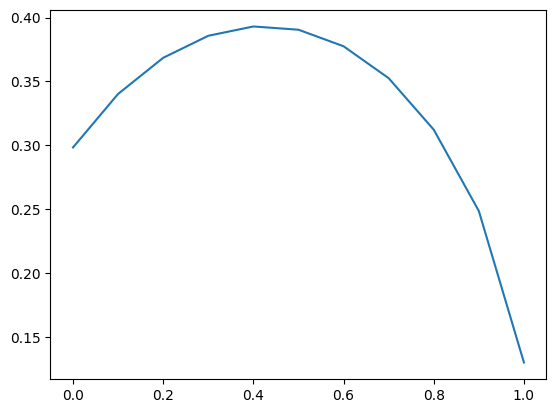

In [17]:
S = np.linspace(0, 1, NumberOfStations, endpoint = True)
Chromossome = OptimumSolution.get_chrom()
Croot_adim = Chromossome["Croot"]
Cmax_adim = Chromossome["Cmax"]
Smax_adim = Chromossome["Smax"]
Ctip_adim = Chromossome["Ctip"]
Pitch_m = Chromossome["Pitch"]
Colective_deg = Chromossome["Collective"]
#c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
d = Croot_adim**2
plt.plot(S, [(a*s**3 + b*s**2 + c*s + d)**0.5 for s in S])
plt.show()

In [ ]:
S = np.linspace(0, 1, NumberOfStations, endpoint = True)
for ind in optimization_NSGA2.return_pareto_front(OptimizationObject.current_pop):
  Chromossome = ind.get_chrom()
  Croot_adim = Chromossome["Croot"]
  Cmax_adim = Chromossome["Cmax"]
  Smax_adim = Chromossome["Smax"]
  Ctip_adim = Chromossome["Ctip"]
  Pitch_m = Chromossome["Pitch"]
  Colective_deg = Chromossome["Collective"]
  #c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
  a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
  b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
  c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
  d = Croot_adim**2
  plt.plot(S, [(a*s**3 + b*s**2 + c*s + d)**0.5 for s in S])
plt.show()

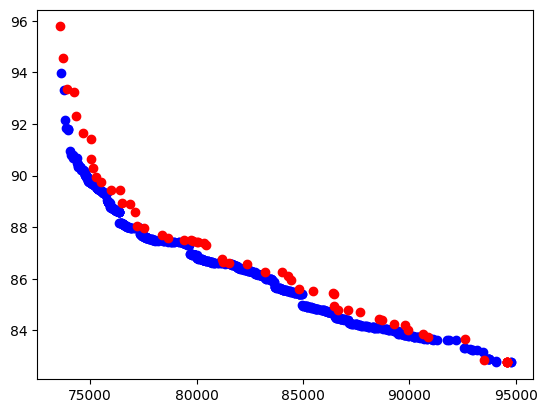

In [13]:
import dill

dill.load_session(f"RunsV4/RUN0_BASELINE.pkl")
for ind in optimization_NSGA2.return_pareto_front(OptimizationObject.current_pop):
  funcs = ind.get_ObjVal()
  plt.plot(funcs[0], funcs[1], 'bo')

dill.load_session(f"RunsV4/RUN36_5.pkl")
for ind in optimization_NSGA2.return_pareto_front(OptimizationObject.current_pop):
  funcs = ind.get_ObjVal()
  plt.plot(funcs[0], funcs[1], 'ro')
plt.show()